In [339]:

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D,Conv1D,MaxPooling1D,UpSampling1D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import sys
import numpy as np

In [54]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)


def load_vectors(client, analogies):
  """Loads and returns analogies and embeddings.

  Args:
    client: the client to query.
    analogies: a list of analogies.

  Returns:
    A tuple with:
    - the embedding matrix itself
    - a dictionary mapping from strings to their corresponding indices
      in the embedding matrix
    - the list of words, in the order they are found in the embedding matrix
  """
  words_unfiltered = set()
  for analogy in analogies:
    words_unfiltered.update(analogy)
  print ("found %d unique words" % len(words_unfiltered))

  vecs = []
  words = []
  index_map = {}
  for word in words_unfiltered:
    try:
      vecs.append(_np_normalize(client.word_vec(word)))
      index_map[word] = len(words)
      words.append(word)
    except KeyError:
      print("word not found: %s" , word)
  print ("words not filtered out: %d" , len(words))

  return np.array(vecs), index_map, words

In [41]:
def load_analogies(filename):
    analogies = []
    with open(filename, "r") as fast_file:
        for line in fast_file:
            line = line.strip()
            # in the analogy file, comments start with :
            if line[0] == ":":
                continue
            words = line.split()
            # there are no misformatted lines in the analogy file, so this should
            # only happen once we're done reading all analogies.
            if len(words) != 4:
                print("Invalid line: " , line)
                continue
            analogies.append(words)
    print("loaded %d analogies" % len(analogies))
    return analogies

In [68]:
def load_vectors(embeddings,analogies):
    X = []
    y = []
    l=[]
    for i in analogies:
        if all(j.lower() in embeddings for j in i):
            B = _np_normalize(embeddings[i[1]])
            C = _np_normalize(embeddings[i[2]])
            A = _np_normalize(embeddings[i[0]])
            D = _np_normalize(embeddings[i[3]])
            X.append(B+C-A)
            y.append(D)
            l.append(i[3])
    return (X,y,l)

In [69]:
(X,y,l) = load_vectors(embeddings,analogies)

In [9]:
import os
import gensim
local_dir_name = 'data'

WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")
embeddings = gensim.models.KeyedVectors.load_word2vec_format(WORD2VEC_FILE, binary=True)
analogies = load_analogies(ANALOGIES_FILE)


loaded 19544 analogies


In [56]:
import numpy as np
wv = load_vectors(embeddings, analogies)[0]

found 905 unique words
words not filtered out: %d 905


In [19]:

model = Sequential()

model.add(Dense(256, input_dim=300))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(1024))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(np.prod(self.img_shape), activation='tanh'))
model.add(Reshape(self.img_shape))

model.summary()
input = Input(shape=(300,))
output = model(input)

NameError: name 'Sequential' is not defined

In [268]:
import sys

import numpy as np

from IPython.core.debugger import Tracer

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt
plt.switch_backend('agg')


class GAN(object):
    def __init__(self):

    
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.G = self.generator()
        self.G.compile(loss='mse', optimizer=self.OPTIMIZER)

        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )

        self.stacked_G_D = self.stacked()
        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        print(self.stacked_G_D.summary())
        
    def generator(self):
            input_size = 300
            hidden_size = 64
            output_size = 300

            model = Sequential()
            # Encoder
            model.add(Dense(164, activation='relu',input_shape=(input_size,)))
            model.add(Dense(64, activation='relu',input_shape=(input_size,)))

            # Decoder
            model.add(Dense(164,activation='sigmoid'))   
            model.add(Dense(output_size, activation='sigmoid'))   
            return model

    def discriminator(self):

        model_adv = Sequential()
        model_adv.add(Dense(300, init='uniform',input_shape=(300,)))
        model_adv.add(Activation('relu'))
        model_adv.add(Dense(100, init='uniform'))
        model_adv.add(Activation('relu'))
        model_adv.add(Dense(1, init='uniform'))
        model_adv.add(Activation('sigmoid'))
        return model_adv

    def stacked(self):
            model = Sequential()
            model.add(self.G)
            model.add(self.D)

            return model

    def train(self, epochs=200, batch = 32, save_interval = 200):

            #train discriminator
            d_loss = self.D.fit(train_vectors, train_targets,epochs=10,batch_size=128,validation_data=(test_vectors,test_targets))
            self.D.trainable = False
            print("trained discriminator")
            # train generator
            g_loss = self.stacked_G_D.fit(wv,np.ones(len(wv))*.5,batch_size=64,epochs=20,shuffle=True)
    #         print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))


gan = GAN()
gan.train()

/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:52: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, kernel_initializer="uniform", input_shape=(300,))`
/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="uniform")`
/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:56: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_36 (Sequential)   (None, 300)               120084    
_________________________________________________________________
sequential_37 (Sequential)   (None, 1)                 120501    
Total params: 240,585
Trainable params: 240,585
Non-trainable params: 0
_________________________________________________________________
None
Train on 5670 samples, validate on 631 samples
Epoch 1/10
5670/5670 [==============================] - 1s 137us/step - loss: 0.6526 - acc: 0.6995 - val_loss: 0.5617 - val_acc: 0.7195
Epoch 2/10
5670/5670 [==============================] - 0s 26us/step - loss: 0.4566 - acc: 0.7316 - val_loss: 0.3402 - val_acc: 0.8304
Epoch 3/10
5670/5670 [==============================] - 0s 27us/step - loss: 0.2797 - acc: 0.9078 - val_loss: 0.2038 - val_acc: 0.9366
Epoch 4/10
5670/5670 [==============================] - 0s 28us/step - los

In [153]:
from keras import backend as K
from keras import losses

In [ ]:
def adv_mean_absolute_error(y_true, y_pred):
    
    return losses.mean_absolute_error(y_true,y_pred)-losses.mean_absolute_error(a_true,a_pred)

In [171]:
def adv_kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def adv_mean_absolute_error(y_true, y_pred):
    y_pred_np = y_pred.eval() 
    a_pred= map(lambda x: lr.predict([x])[1],y_pred_np)
#     a_pred= K.map_fn(lambda x: lr.predict([x.eval(session=K.get_session())])[1],y_pred)
    a_true = np.ones(len(y_true))*.5
    return losses.mean_absolute_error(y_true,y_pred)-losses.mean_absolute_error(a_true,a_pred)

In [157]:

def adv_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def adv_mean_absolute_error(y_true, y_pred):
    a_pred= K.map_fn(lambda x: lr.predict(x[1]),y_pred)
    l_adv = K.mean(K.binary_crossentropy(y_true, a_pred), axis=-1)
    return K.mean(K.abs(y_pred - y_true), axis=-1)-l_adv

In [ ]:
def adv_binary_crossentropy(y_true, y_pred):
return -K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)+

In [321]:
identities_wv = np.array(map(lambda x: embeddings[x.lower()], filter(lambda x: x.lower() in embeddings,gender)))

In [432]:
x = Input(shape=(input_size,))

encoder = Dense(input_size, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(x)
encoder = Dense(int(input_size/ 2), activation="relu")(encoder)

decoder = Dense(int(input_size / 2), activation='tanh')(encoder)
decoder = Dense(input_size, activation='relu')(decoder)

autoencoder = Model(inputs=x, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='kullback_leibler_divergence')
autoencoder.fit(wv,wv,batch_size=900,epochs=100,shuffle=True)

Epoch 1/100
905/905 [==============================] - 1s 1ms/step - loss: 45.5713
Epoch 2/100
905/905 [==============================] - 0s 19us/step - loss: 37.0855
Epoch 3/100
905/905 [==============================] - 0s 19us/step - loss: 30.4100
Epoch 4/100
905/905 [==============================] - 0s 20us/step - loss: 24.0541
Epoch 5/100
905/905 [==============================] - 0s 22us/step - loss: 18.6177
Epoch 6/100
905/905 [==============================] - 0s 21us/step - loss: 13.8553
Epoch 7/100
905/905 [==============================] - 0s 20us/step - loss: 9.5540
Epoch 8/100
905/905 [==============================] - 0s 20us/step - loss: 6.0487
Epoch 9/100
905/905 [==============================] - 0s 21us/step - loss: 3.1738
Epoch 10/100
905/905 [==============================] - 0s 22us/step - loss: 0.7754
Epoch 11/100
905/905 [==============================] - 0s 21us/step - loss: -1.2408
Epoch 12/100
905/905 [==============================] - 0s 20us/step - loss: -2

905/905 [==============================] - 0s 22us/step - loss: -17.0329
Epoch 97/100
905/905 [==============================] - 0s 21us/step - loss: -17.0339
Epoch 98/100
905/905 [==============================] - 0s 20us/step - loss: -17.0364
Epoch 99/100
905/905 [==============================] - 0s 20us/step - loss: -17.0377
Epoch 100/100
905/905 [==============================] - 0s 22us/step - loss: -17.0400


In [369]:
x = Input(shape=(input_size,1))

# Encoder
conv1_1 = Conv1D(32, 3, activation='relu', padding='same')(x)
pool1 = MaxPooling1D(2, padding='same')(conv1_1)
conv1_2 = Conv1D(32, 3, activation='relu', padding='same')(pool1)
h = MaxPooling1D(2, padding='same')(conv1_2)


# Decoder
conv2_1 = Conv1D(32, 3, activation='relu', padding='same')(h)
up1 = UpSampling1D(2)(conv2_1)
conv2_2 = Conv1D(32, 3, activation='relu', padding='same')(up1)
up2 = UpSampling1D(2)(conv2_2)
r = Conv1D(1, 3, activation='sigmoid', padding='same')(up2)

autoencoder = Model(input=x, output=r)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(np.expand_dims(wv,axis=2),np.expand_dims(wv,axis=2),batch_size=900,epochs=100,shuffle=True)

/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`


Epoch 1/100
905/905 [==============================] - 1s 1ms/step - loss: 0.2530
Epoch 2/100
905/905 [==============================] - 0s 201us/step - loss: 0.2465
Epoch 3/100
905/905 [==============================] - 0s 205us/step - loss: 0.2388
Epoch 4/100
905/905 [==============================] - 0s 213us/step - loss: 0.2291
Epoch 5/100
905/905 [==============================] - 0s 211us/step - loss: 0.2168
Epoch 6/100
905/905 [==============================] - 0s 203us/step - loss: 0.2011
Epoch 7/100
905/905 [==============================] - 0s 214us/step - loss: 0.1813
Epoch 8/100
905/905 [==============================] - 0s 214us/step - loss: 0.1569
Epoch 9/100
905/905 [==============================] - 0s 206us/step - loss: 0.1281
Epoch 10/100
905/905 [==============================] - 0s 210us/step - loss: 0.0961
Epoch 11/100
905/905 [==============================] - 0s 212us/step - loss: 0.0643
Epoch 12/100
905/905 [==============================] - 0s 206us/step - loss

Epoch 97/100
905/905 [==============================] - 0s 207us/step - loss: 0.0033
Epoch 98/100
905/905 [==============================] - 0s 208us/step - loss: 0.0033
Epoch 99/100
905/905 [==============================] - 0s 209us/step - loss: 0.0033
Epoch 100/100
905/905 [==============================] - 0s 217us/step - loss: 0.0033


In [448]:
from keras import regularizers
input_size = 300
hidden_size = 64
output_size = 300

x = Input(shape=(input_size,))

# Encoder
h = Dense(300, activation=None, activity_regularizer=regularizers.l1(10e-5))(x)
# h = Dense(164, activation='relu',activity_regularizer=regularizers.l1(10e-5))(h)
# # Decoder
# r = Dense(output_size, activation='relu',activity_regularizer=regularizers.l1(10e-5))(h)
# r = Dense(output_size, activation='sigmoid')(r)

autoencoder = Model(input=x, output=h)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(wv,wv,batch_size=900,epochs=20,shuffle=True)

/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 300)               0         
_________________________________________________________________
dense_179 (Dense)            (None, 300)               90300     
Total params: 90,300
Trainable params: 90,300
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
905/905 [==============================] - 1s 1ms/step - loss: 1.2621
Epoch 2/20
905/905 [==============================] - 0s 13us/step - loss: 1.1870
Epoch 3/20
905/905 [==============================] - 0s 15us/step - loss: 1.1328
Epoch 4/20
905/905 [==============================] - 0s 14us/step - loss: 1.0880
Epoch 5/20
905/905 [==============================] - 0s 13us/step - loss: 1.0491
Epoch 6/20
905/905 [==============================] - 0s 13us/step - loss: 1.0149
Epoch 7/20
905/905 [=======================

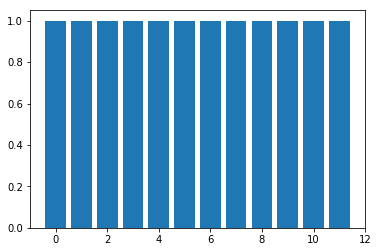

In [433]:
%matplotlib inline 
#is this like radial basis function making everything equal
op = []
for i in gender:
    if i.lower() in embeddings:
        o=np.expand_dims(embeddings[i.lower()],axis=0)
        op.append(lr.predict_proba([autoencoder.predict(o)[0,:]])[0][1])
plt.bar(np.arange(len(op)),op)
plt.show()

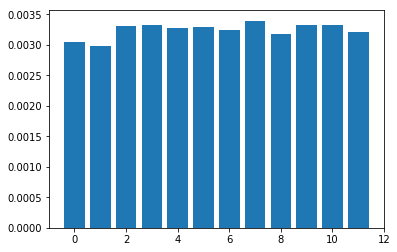

In [371]:
%matplotlib inline 
#is this like radial basis function making everything equal

op = []
for i in gender:
    if i.lower() in embeddings:
        op.append(lr.predict_proba([gan.G.predict(np.expand_dims(embeddings[i.lower()],axis=0))[0,:]])[0][1])
plt.bar(np.arange(len(op)),op)
plt.show()

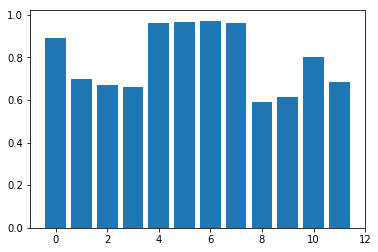

In [372]:
%matplotlib inline 
#is this like radial basis function making everything equal
op = []
for i in gender:
    if i.lower() in embeddings:
        op.append(lr.predict_proba([embeddings[i.lower()]])[0][1])
plt.bar(np.arange(len(op)),op)
plt.show()

In [434]:
a = embeddings["athens"]
b = embeddings["greece"]
c = embeddings["moscow"]
d = embeddings["male"]

In [435]:
embeddings.similar_by_vector(b+c-a)

[(u'greece', 0.7920663952827454),
 (u'moscow', 0.7169557213783264),
 (u'europe', 0.5698994398117065),
 (u'malta', 0.5560809373855591),
 (u'serbia', 0.5415053367614746),
 (u'cristiano_ronaldo', 0.5405558347702026),
 (u'norway', 0.5325840711593628),
 (u'portugal', 0.5311784744262695),
 (u'russia', 0.5276082158088684),
 (u'spain', 0.5275852680206299)]

In [436]:
embeddings.similar_by_vector(gan.G.predict(np.expand_dims(b+c-a,axis=0))[0,:])

[(u'Website_http://www.cgi.com', 0.25435882806777954),
 (u'AP_HOCKEY_NEWS', 0.22141584753990173),
 (u'aide_Melanie_Fonder', 0.21890948712825775),
 (u'week.But', 0.21821339428424835),
 (u'TBLISI_Georgia', 0.21708080172538757),
 (u'Cindy_Crawford', 0.2166801244020462),
 (u'Ovidiu_Rom', 0.2155206799507141),
 (u'Residential_Tenancies_Amendment', 0.2123904973268509),
 (u'EPP_ED_PL', 0.21208089590072632),
 (u'etwcf', 0.21192854642868042)]

In [438]:
embeddings.similar_by_vector(autoencoder.predict(np.expand_dims(np.expand_dims(b+c-a,axis=0),axis=2))[0,:,0])

ValueError: Error when checking : expected input_41 to have 2 dimensions, but got array with shape (1, 300, 1)

In [439]:
embeddings.similar_by_vector(embeddings[p])

[(u'her', 0.9999999403953552),
 (u'she', 0.7834683656692505),
 (u'herself', 0.7382731437683105),
 (u'Her', 0.7029306888580322),
 (u'hers', 0.6714211702346802),
 (u'his', 0.6359063386917114),
 (u'She', 0.622606635093689),
 (u'my', 0.5852576494216919),
 (u"Je_t'aime_Papou", 0.5452724695205688),
 (u'mother', 0.5382469296455383)]

In [440]:
embeddings.similar_by_vector(gan.G.predict(np.expand_dims(embeddings[p],axis=0))[0,:])

[(u'Website_http://www.cgi.com', 0.2545045018196106),
 (u'AP_HOCKEY_NEWS', 0.2215508222579956),
 (u'aide_Melanie_Fonder', 0.21896588802337646),
 (u'week.But', 0.21843330562114716),
 (u'TBLISI_Georgia', 0.21695643663406372),
 (u'Cindy_Crawford', 0.2166750431060791),
 (u'Ovidiu_Rom', 0.21495576202869415),
 (u'Residential_Tenancies_Amendment', 0.21293756365776062),
 (u'EPP_ED_PL', 0.21205320954322815),
 (u'Gretel_Packer', 0.2117219865322113)]

In [445]:
embeddings.similar_by_vector(autoencoder.predict(np.expand_dims(embeddings[p],axis=0))[0,:])

[(u'salty_snack', 0.2719143033027649),
 (u'eaten', 0.2561814785003662),
 (u'\xc9lys\xe9e_Palace', 0.2546929717063904),
 (u'LiveSmart_Adult_Lamb', 0.2510547637939453),
 (u'Jamie_Gorelick', 0.2503967881202698),
 (u'Governor_Goodhair', 0.24670206010341644),
 (u'coyotes_circling', 0.24638763070106506),
 (u'aide_Rashid_Qureshi', 0.2457980513572693),
 (u'drummers_drumming_purchased', 0.24541160464286804),
 (u'finicky_eating_habits', 0.24303007125854492)]

In [380]:
p = "her"

In [381]:
lr.predict_proba([autoencoder.predict(np.expand_dims(embeddings[p],axis=0))[0,:]])

ValueError: Error when checking : expected input_36 to have 3 dimensions, but got array with shape (1, 300)

In [382]:
lr.predict_proba([gan.G.predict(np.expand_dims(embeddings[p],axis=0))[0,:]])

array([[0.9966915, 0.0033085]])

In [383]:
lr.predict_proba([embeddings[p]])

array([[0.32957804, 0.67042196]])

In [453]:
analogy_accuracy(X,l,embeddings,model=autoencoder)

m
0.1
0.2
0.3
0.4
0.5
0.6
m
m
0.7
m
0.8
m
0.9
1.0


0.0

In [452]:
def analogy_accuracy(X,y,embeddings,n = 5,samples=100,model=None):
    correct = 0
    count = 0
    for i in np.random.choice(np.shape(X)[0],samples):
        count+=1
        if count % 10 ==0:
            print(count/float(samples))
        vec = model.predict(np.expand_dims(X[i],axis=0))[0,:] if model else X[i]
        for j in embeddings.similar_by_vector(vec,topn=n):
            try:
                if l[i] == str(j[0]): 
                    correct+=1
                    break
            except:
                print("m")
    return float(correct)/samples

In [83]:
import numpy as np
import gensim
import pandas as pd
from matplotlib import pyplot as plt
import seaborn
import re
import statsmodels.formula.api
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib nbagg

## Protected Groups

Race,
Color,
Religion or creed,
National origin or ancestry,
Sex,
Age,
Physical or mental disability,
Veteran status,
Genetic information,
Citizenship

In [237]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']

In [238]:
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]

In [239]:
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
    'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
    'Diasporic',
    'Sikh',
    'Juche',
    'Jewish',
    'Bahai',
    'Jains',
    'Shinto',
    'Pagan'
]

In [240]:
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

## Utility methods

In [73]:
def text_to_vector(embeddings,text):
    tokens = text.split()
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        return np.mean(embeddings[words],axis = 0)
    return None

In [74]:
def words_to_toxicity(model,embeddings,words):
    words = filter(lambda x: x in embeddings,[x.lower() for x in words])
    if len(words)>0:
        vector = np.mean(embeddings[words],axis = 0)
        prob = model.predict_prob(vector)
        return prob
    else: return 0;

In [75]:
def text_to_toxicity(model,embeddings,text):
    tokens = text.split()
    toxicity = words_to_toxicity(model,embeddings,tokens)
    return toxicity

In [76]:
def identity_toxicity_table(identities,embeddings,model,add=None):
    words = []
    toxicities = []
    for word in sorted(identities):
        word = add + word if add else word
        word = word.lower()
        toxicities.append(text_to_toxicity(model, embeddings,word.lower()))
        words.append(word)
    return zip(words,toxicities)

In [77]:
def load_lexicon(filename):
    lexicon = []
    with open(filename) as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [79]:
def generate_train_test_set(model,targets,sentences,dim=300):
    vectors = np.zeros((len(sentences),dim))
    labels = np.zeros((len(sentences)))
    count=0
    for i,sentence in enumerate(sentences):
        words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
        if len(words)>0:
            vectors[count,:] = np.mean(model[words],axis = 0)
            labels[count] = targets[i] 
            count+=1
    print(count, " sentences in embeddings, ", len(sentences) - count, " sentences not in embeddings")
    return train_test_split(vectors, labels, test_size=0.1, random_state=0)

## Load Datasets

In [105]:
#GLOVE
# from gensim.scripts.glove2word2vec import glove2word2vec
# glove_input_file = 'data/glove.6B/glove.6B.300d.txt'
# word2vec_output_file = 'data/glove.6B/glove.6B.300d.txt.word2vec'
# glove2word2vec(glove_input_file, word2vec_output_file)
# embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

#Word2vec
embeddings = gensim.models.KeyedVectors.load_word2vec_format('data/embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

#universal sentence encoder
# import tensorflow as tf
# import tensorflow_hub as hub
# module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# # Import the Universal Sentence Encoder's TF Hub module
# embed = hub.Module(module_url)

In [81]:
#kaggle

#df = pd.read_csv("data/kaggle_toxicity/train.csv")

#word sentiment

pos_words = load_lexicon("data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("data/opinion_lexicon/negative-words.txt")

#imbd

# import numpy
# from keras.datasets import imdb
# from matplotlib import pyplot
# # load the dataset
# (X_train, y_train), (X_test, y_test) = imdb.load_data()
# X = numpy.concatenate((X_train, X_test), axis=0)
# y = numpy.concatenate((y_train, y_test), axis=0)

## Initialize word sentiment dataset or toxicity dataset (wiki)

In [211]:
#sentiment word dataset from positve/negative reviews
#'''
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
labels = list(pos_vectors) + list(neg_vectors)
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
lr = LogisticRegression()
lr.fit(train_vectors,train_targets)
lr.score(test_vectors,test_targets)
#'''
#toxicity tweet dataset
#''''''
# toxic_sentences = df[df["toxic"]==1]["comment_text"]
# num_toxic_samples = len(toxic_sentences)
# non_toxic_sentences = df[df["toxic"]==0]["comment_text"].sample(num_toxic_samples)
# sentences = pd.concat([toxic_sentences, non_toxic_sentences])
# targets  = np.zeros(num_toxic_samples*2)
# targets[0:num_toxic_samples] = 1
# train_vectors, test_vectors, train_targets, test_targets = generate_train_test_set(embeddings,targets,sentences)
# sentences = map(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x.lower()),list(sentences))
# # message_embeddings = None
# # with tf.Session() as session:
# #     session.run([tf.global_variables_initializer(), tf.tables_initializer()])
# #     message_embeddings = session.run(embed(sentences))
# #     print np.shape(message_embeddings)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vec = TfidfVectorizer(ngram_range=(1,2),
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1)
# trn_term_doc = vec.fit_transform(sentences)

# train_vectors, test_vectors, train_targets, test_targets = train_test_split(trn_term_doc.todense(), targets,test_size=0.1, random_state=0)

#'''


    
# import re, string
# re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
# def tokenize(s): return re_tok.sub(r' \1 ', s).split()
# n = train.shape[0]
# vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
#                min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
#                smooth_idf=1, sublinear_tf=1 )
# trn_term_doc = vec.fit_transform(train[COMMENT])
# test_term_doc = vec.transform(test[COMMENT])
#imbd movie ratings?????

0.9492868462757528

In [177]:
np.shape(train_vectors)

(5670, 300)

In [192]:
model_adv = Sequential()
model_adv.add(Dense(300, init='uniform',input_shape=(300,)))
model_adv.add(Activation('relu'))
model_adv.add(Dense(100, init='uniform'))
model_adv.add(Activation('relu'))
model_adv.add(Dense(1, init='uniform'))
model_adv.add(Activation('sigmoid'))

model_adv.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.02),metrics=['accuracy'])
model_adv.fit(train_vectors, train_targets,epochs=10,batch_size=128,validation_data=(test_vectors,test_targets))

/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(300, kernel_initializer="uniform", input_shape=(300,))`
  
/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`
  


Train on 5670 samples, validate on 631 samples
Epoch 1/10
5670/5670 [==============================] - 0s 82us/step - loss: 0.2265 - acc: 0.9028 - val_loss: 0.1315 - val_acc: 0.9493
Epoch 2/10
5670/5670 [==============================] - 0s 27us/step - loss: 0.1079 - acc: 0.9621 - val_loss: 0.1183 - val_acc: 0.9509
Epoch 3/10
5670/5670 [==============================] - 0s 27us/step - loss: 0.0755 - acc: 0.9730 - val_loss: 0.1198 - val_acc: 0.9509
Epoch 4/10
5670/5670 [==============================] - 0s 25us/step - loss: 0.0547 - acc: 0.9802 - val_loss: 0.1699 - val_acc: 0.9445
Epoch 5/10
5670/5670 [==============================] - 0s 25us/step - loss: 0.0487 - acc: 0.9817 - val_loss: 0.1582 - val_acc: 0.9556
Epoch 6/10
5670/5670 [==============================] - 0s 27us/step - loss: 0.0248 - acc: 0.9919 - val_loss: 0.1848 - val_acc: 0.9540
Epoch 7/10
5670/5670 [==============================] - 0s 28us/step - loss: 0.0139 - acc: 0.9951 - val_loss: 0.2288 - val_acc: 0.9588
Epoch 8/

In [194]:
model_adv.evaluate(test_vectors)

TypeError: evaluate() takes at least 3 arguments (2 given)

In [85]:
def _np_normalize(v):
  """Returns the input vector, normalized."""
  return v / np.linalg.norm(v)
words = set()
for a in analogies:
  words.update(a)

<BarContainer object of 100 artists>

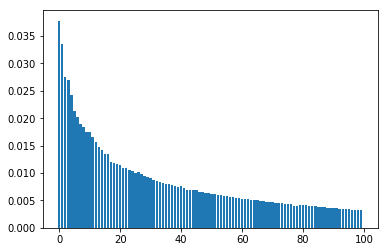

In [107]:
import nltk 
from nltk.corpus import wordnet 
good = []
bad=  []

for word in pos_words:
    a = wordnet.synsets(word)
    if len(a)>0:
        syn = a[0] .lemmas()[0]
        if len(syn.antonyms())>0:
            good.append(word)
            bad.append(syn.antonyms()[0].name()) 
good_vectors=[]
bad_vectors = []
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.cov(X.T)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

In [115]:
for i in filter(lambda x: x.lower() in embeddings,identities):
    print i, embeddings.most_similar(i)[:2]

 lesbian [(u'gay', 0.8117855787277222), (u'lesbians', 0.7656285762786865)]
gay [(u'homosexual', 0.8145633339881897), (u'lesbian', 0.8117855787277222)]
bisexual [(u'heterosexual', 0.6771868467330933), (u'bisexuals', 0.6483285427093506)]
transgender [(u'transgendered', 0.8865242600440979), (u'transgendered_GLBT', 0.7773934602737427)]
trans [(u'sodium_TSC', 0.6333322525024414), (u'transgender_transsexual', 0.49470755457878113)]
queer [(u'genderqueer', 0.7026611566543579), (u'LGBTQ', 0.6990917325019836)]
lgbt [(u'LGBT', 0.6653385162353516), (u'LGBTQ', 0.6460728049278259)]
homosexual [(u'gay', 0.8145633339881897), (u'homosexuals', 0.7716525793075562)]
straight [(u'consecutive', 0.7644870281219482), (u'staight', 0.5966242551803589)]
heterosexual [(u'heterosexuals', 0.7658922672271729), (u'homosexual', 0.710830569267273)]
male [(u'female', 0.8405333161354065), (u'males', 0.7579617500305176)]
female [(u'male', 0.8405333757400513), (u'Female', 0.7159764766693115)]
african [(u'africa', 0.6802803

<BarContainer object of 100 artists>

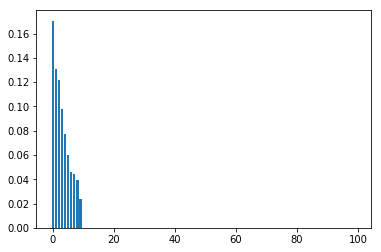

In [108]:
good = ['good','beautiful','happy','positive','compentent','smart','interesting','pleasant','best','honest','wealthy','wonderful']
bad = ['bad','ugly','sad','negative','incompetent','dumb','boring','horrible','worst','corrupt','poor','awful']
good_vectors=[]
bad_vectors = []
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.cov(X.T)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

In [111]:
words = ["beautiful","ugly"]#filter(lambda x: x.lower() in embeddings,identities)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: embeddings[w.lower()].dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df

        word  sentiment_score
1       ugly        -1.098870
0  beautiful         0.824158


In [19]:
np.shape(pos_vectors),np.shape(neg_vectors)

((1893, 300), (4344, 300))

## Create fair regression terms

In [17]:
N = np.zeros((len(nationalities),300))
for i,j in enumerate(nationalities):
    N[i,:] = embeddings[j.lower()]
R = np.zeros((len(religions),300))
for i,j in enumerate(religions):
    R[i,:] = embeddings[j.lower()]
G = np.zeros((len(gender),300))
for i,j in enumerate(gender):
    G[i,:] = embeddings[j.lower()]
regularizers = [N,R,G]